In [1]:
import pandas as pd
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoConfig, AutoTokenizer

comet_ml is installed but `COMET_API_KEY` is not set.


In [2]:
df = pd.read_json("all_feedback (2).json.gz", lines=True)

In [3]:
df.columns

Index(['lang', 'created_at', 'text', 'author_id', 'retweet_count',
       'reply_count', 'like_count', 'quote_count', 'total_result_count',
       'attachments', 'twitter_attachment_type', 'referenced_tweets',
       'text_data', 'date_data', 'user_data', 'twitter_retweet_count',
       'twitter_reply_count', 'twitter_like_count', 'twitter_quote_count',
       'app_name', 'platform_name', 'twitter_dev_replied', 'meta_app_id',
       'meta_platform_app_id', 'meta_platform_id', 'geo', 'withheld', 'title',
       'reddit_score', 'url', 'reddit_number_comments', 'created', 'body',
       'reddit_flair', 'media', 'media_only', 'author_name',
       'reddit_media_domain', 'reddit_url_suffix', 'date', 'name', 'helpful',
       'rating', 'review_text', 'reply_text', 'reply_date', 'google_rating',
       'google_dev_reply', 'google_helpful', 'updated', 'content', 'link',
       'voteSum', 'voteCount', 'version', 'author', 'region', 'apple_rating',
       'apple_region'],
      dtype='object')

In [4]:
df[['text_data', 'date_data', 'meta_app_id', 'meta_platform_id']].sample(n=5)

,text_data,date_data,meta_app_id,meta_platform_id
120991,http://+44%207464%20687935. http://+44%207464%...,1588718852000,zoom,Apple App Store
114167,Mode sombre. Ça serait cool de permettre de me...,1617963081000,snapchat,Apple App Store
146593,We miss you in Germany. Awesome customer suppo...,1579116683000,deliveroo,Apple App Store
109216,J. Great,1586398975000,slack,Apple App Store
49584,Any real benefit of leagues?. I don't see any ...,1618322837000,duolingo,Reddit


In [5]:
df["feedback_text"] = df["text_data"]

In [6]:
df['meta_platform_id'].value_counts()

Apple App Store      87478
Google Play Store    43600
Twitter              39706
Reddit               20572
Support Twitter       1050
Technical Reddit       975
Name: meta_platform_id, dtype: int64

In [7]:
label_granularity = "bug_feature_other"
model_name = "distilbert-base-uncased"
label_granularity = "requirements_relevance"
is_multiclass = not (label_granularity == "requirements_relevance")
problem_type = "multi_label_classification" if is_multiclass else "single_label_classification"

In [8]:
label_order = ['bug', 'feature', 'other']

In [9]:
from dataset_preparation import FeedbackDataset
import numpy as np
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenized_text = tokenizer(text = df.feedback_text.tolist(), padding=True, truncation=True, max_length=256, return_tensors="np")

if is_multiclass:
    dataset = FeedbackDataset(tokenized_text, None, is_multiclass=True)
else:
    dataset = FeedbackDataset(tokenized_text, None, is_multiclass=False)

In [11]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoConfig, AutoTokenizer
import torch
from sklearn.metrics import brier_score_loss, accuracy_score, precision_recall_fscore_support, ndcg_score, roc_auc_score

def get_aprf1(labels, pred_label):
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred_label, average='binary', zero_division=0)
    acc = accuracy_score(labels, pred_label)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def get_cutoff_metrics(labels, preds, cutoff):
    pred_label = preds > cutoff
    metrics = get_aprf1(labels, pred_label)
    return {f"{k}_{cutoff}": v for k, v in metrics.items()}

def multiclass_compute_metrics(eval_pred):
    
    logits, labels = eval_pred
    
    sig = torch.nn.Sigmoid()
    perc_preds = sig(torch.Tensor(logits)).numpy()
    
    results = {}
    
    num_pred_classes = logits.shape[1]
    for class_num in range(num_pred_classes):
        class_name = label_order[class_num]
        
        class_perc_preds = perc_preds[:, class_num]
        class_labels = labels[:, class_num]

        results[f"{class_name}_roc_auc"] = roc_auc_score(class_labels, class_perc_preds)
        cutoff_metrics = get_cutoff_metrics(class_labels, class_perc_preds, 0.5)
        cutoff_metrics = {f"{class_name}_{k}":v for k, v in cutoff_metrics.items()}
        results.update(cutoff_metrics)
    
    return results

def singleclass_compute_metrics(eval_pred):
    
    logits, labels = eval_pred
    
    predictions = np.argmax(logits, axis=-1)
    results = get_aprf1(labels, predictions)

    return results

compute_metrics = multiclass_compute_metrics if is_multiclass else singleclass_compute_metrics

training_args = TrainingArguments(
    output_dir=f'./results_test_{label_granularity}',          # output directory
    per_device_eval_batch_size=64,   # batch size for evaluation
    logging_dir=f'./logs_test_{label_granularity}',            # directory for storing logs
    fp16=True,
)

config = AutoConfig.from_pretrained(model_name, cache_dir="/mnt/Research/peter-research/peter_devine_nlp_models")
num_labels = 3 if label_granularity == "bug_feature_other" else 2
config.num_labels = num_labels
config.problem_type = problem_type
model = AutoModelForSequenceClassification.from_config(config)
model.load_state_dict(torch.load(f"/home/pdev438/projects/user_feedback_labeller/results_{label_granularity}/pytorch_model.bin"))

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=dataset,         # training dataset
    eval_dataset=dataset,             # evaluation dataset
    compute_metrics=compute_metrics,
)

In [ ]:
prediction_result = trainer.predict(dataset)

In [ ]:
perc_preds = np.argmax(prediction_result.predictions, axis=-1)

In [15]:
sig = torch.nn.Sigmoid()
perc_preds = sig(torch.Tensor(prediction_result.predictions)).numpy()


perc_preds

array([[0.03422932, 0.03265138, 0.9579909 ],
       [0.09401018, 0.06730107, 0.9467938 ],
       [0.41211605, 0.2148561 , 0.6788595 ],
       ...,
       [0.01073516, 0.00498227, 0.990732  ],
       [0.00382448, 0.00609756, 0.9945095 ],
       [0.0057974 , 0.38456538, 0.7879312 ]], dtype=float32)

In [56]:
results = {}

for platform_name in df['meta_platform_id'].unique():
    results[platform_name] = {}
    for app_name in df['meta_app_id'].unique():
        app_platform_mask = (df['meta_platform_id'] == platform_name) & (df['meta_app_id'] == app_name)
        
        results[platform_name][app_name] = {}
        for i, label_name in enumerate(label_order):
            results[platform_name][app_name][label_name] = (perc_preds[app_platform_mask, i] > 0.5).mean()

/home/pdev438/miniconda3/envs/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
/home/pdev438/miniconda3/envs/jupyter_env/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [57]:
metric_results = {}

for label_name in label_order:
    
    metric_results[label_name] = {plat: {app: app_v[label_name] for app, app_v in plat_v.items()} for plat, plat_v in results.items()}

<AxesSubplot:>

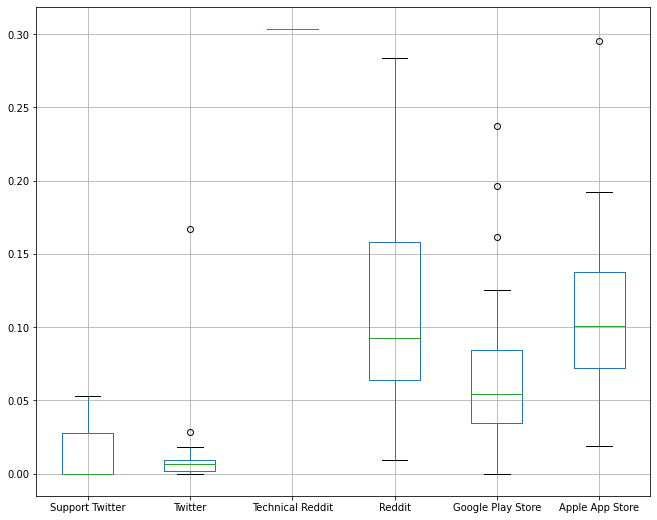

In [65]:
pd.DataFrame(metric_results['bug']).boxplot(figsize=(11,9))

In [52]:

pd.DataFrame(metric_results['bug']).div(pd.DataFrame(metric_results['bug']).sum(axis=1), axis=0)

,Support Twitter,Twitter,Technical Reddit,Reddit,Google Play Store,Apple App Store
firefox,0.000000,0.006897,0.000000,0.227586,0.063793,0.701724
github,0.000000,0.029851,0.000000,0.589552,0.000000,0.380597
snapchat,0.004058,0.002899,0.171594,0.005217,0.277101,0.539130
bumble,0.000000,0.002421,0.000000,0.142857,0.106538,0.748184
twitch,0.020270,0.027027,0.000000,0.140766,0.068694,0.743243
binance,0.009381,0.022514,0.000000,0.112570,0.200750,0.654784
deliveroo,0.000000,0.009569,0.000000,0.220096,0.090909,0.679426
fitbit,0.001087,0.007609,0.000000,0.123913,0.161957,0.705435
wish,0.000000,0.000000,0.000000,0.084175,0.161616,0.754209
slack,0.000000,0.002037,0.000000,0.187373,0.038697,0.771894


<AxesSubplot:>

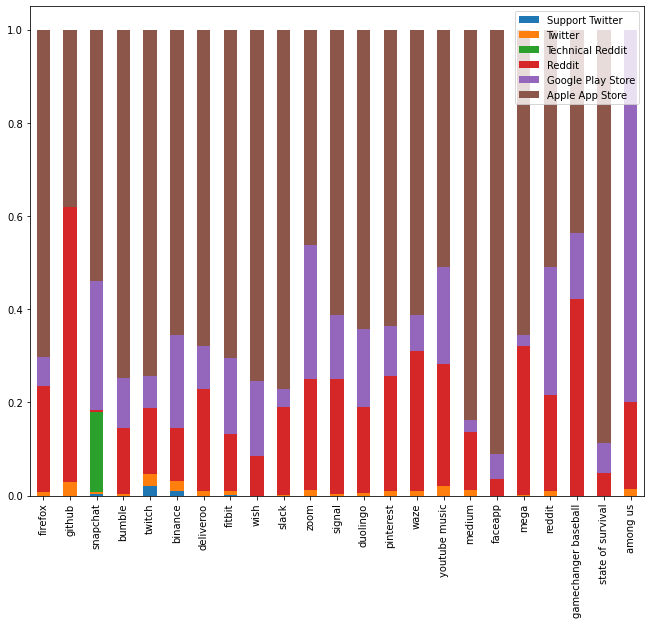

In [55]:
(pd.DataFrame(metric_results['bug']).div(pd.DataFrame(metric_results['bug']).sum(axis=1), axis=0)).plot.bar(stacked=True, figsize=(11,9))

In [44]:
app_platform_mask = (df['meta_platform_id'] == "Support Twitter") & (df['meta_app_id'] == "twitch")
df[app_platform_mask][(perc_preds[app_platform_mask, 0] > 0.5)].feedback_text.tolist()

["I'm trying to log back into my twitch acc and it wont let me? It says that it sent a code to my gmail but it didnt like? @TwitchSupport",
 "I've been having this problem where no1 can hear me when I stream everyone I play wit can hear me in game but can't hear me in stream It's been like this for a few days and I haven't been streaming because of it! I stream on xbox anyone else have this problem?@TwitchSupport",
 "Hey @TwitchSupport I have a bug where a stream from one channel (RyonkaFactory) in particular won't load. Doesn't work from my browser &amp; phone and i tried switching to 4G. Chat works and other peoples seem to see the stream without problem. Any idea ?",
 'Hello @AskPlayStation , I’m unable to stream on my PS5 it keeps saying my account is linked to another account but I only have one PlayStation account, please help me as @TwitchSupport is useless and puts the blame on y’all',
 "just had to end my stream after 3 minutes because it is completely unwatchable, noti's don'

In [17]:
platform_metrics = {}

for platform_name in df.feedback_platform.unique():
    platform_df = df[df.feedback_platform == platform_name]
    
    tokenized_text = tokenizer(text = platform_df.feedback_text.tolist(), padding=True, truncation=True, max_length=256, return_tensors="np")
    
    if is_multiclass:
        dataset = FeedbackDataset(tokenized_text, platform_df[["is_bug", "is_feat", "is_oth"]].values, is_multiclass=True)
    else:
        dataset = FeedbackDataset(tokenized_text, np.argmax(platform_df[["is_irrel", "is_rel"]].values, axis=1), is_multiclass=False)
    metrics = trainer.predict(dataset).metrics
    metrics["perc_pos_irrel"] = platform_df.is_irrel.mean()
    metrics["perc_pos_rel"] = platform_df.is_rel.mean()
    if is_multiclass:
        metrics["perc_pos_is_bug"] = platform_df.is_bug.mean()
        metrics["perc_pos_is_feat"] = platform_df.is_feat.mean()
        metrics["perc_pos_is_oth"] = platform_df.is_oth.mean()
    platform_metrics[platform_name] = metrics

/home/pdev438/miniconda3/envs/jupyter_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:65: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/pdev438/miniconda3/envs/jupyter_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:65: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/pdev438/miniconda3/envs/jupyter_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:65: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/pdev438/miniconda3/envs/jupyter_env/lib/python3.7/site-packages/torch/nn/parallel/

In [18]:
pd.DataFrame(platform_metrics)

,Apple App Store,Spotify forum,Google Play Store,Reddit,Twitter
test_loss,0.441477,0.768893,0.299863,0.556092,0.470704
test_bug_roc_auc,0.895010,0.891131,0.965618,0.899185,0.914880
test_bug_accuracy_0.5,0.860000,0.680000,0.890000,0.810000,0.890000
test_bug_f1_0.5,0.650000,0.652174,0.702703,0.698413,0.731707
test_bug_precision_0.5,0.928571,0.967742,0.866667,0.846154,0.681818
test_bug_recall_0.5,0.500000,0.491803,0.590909,0.594595,0.789474
test_feature_roc_auc,0.796263,0.630937,0.846917,0.541857,0.598238
test_feature_accuracy_0.5,0.760000,0.620000,0.820000,0.570000,0.750000
test_feature_f1_0.5,0.520000,0.472222,0.470588,0.317460,0.324324
test_feature_precision_0.5,0.448276,0.515152,0.470588,0.277778,0.315789


In [11]:
dataset[100:110]

{'input_ids': tensor([[  101,  2190,  2189,  ...,     0,     0,     0],
         [  101,  1045,  2293,  ...,     0,     0,     0],
         [  101,  2190,  2377,  ...,     0,     0,     0],
         ...,
         [  101, 10439,  2562,  ...,     0,     0,     0],
         [  101,  3115,  2028,  ...,     0,     0,     0],
         [  101,  2006,  2026,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([0, 0, 0, 0, 1, 1, 0, 1, 0, 1])}